- 参考链接 
- [LOESS_MSTL](https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html#Multiple-Seasonal-Trend-decomposition-using-LOESS-(MSTL))

In [ ]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

register_matplotlib_converters()
sns.set_style("darkgrid")


In [3]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [4]:
t = np.arange(1, 1000)
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
trend = 0.0001 * t**2
y = trend + daily_seasonality + weekly_seasonality + np.random.randn(len(t))
ts = pd.date_range(start="2020-01-01", freq="H", periods=len(t))
df = pd.DataFrame(data=y, index=ts, columns=["y"])

/tmp/ipykernel_2520/288299940.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = pd.date_range(start="2020-01-01", freq="H", periods=len(t))


In [6]:
df.head()

,y
2020-01-01 00:00:00,2.857268
2020-01-01 01:00:00,5.257472
2020-01-01 02:00:00,4.099270
2020-01-01 03:00:00,5.859494
2020-01-01 04:00:00,6.656489


<Axes: >

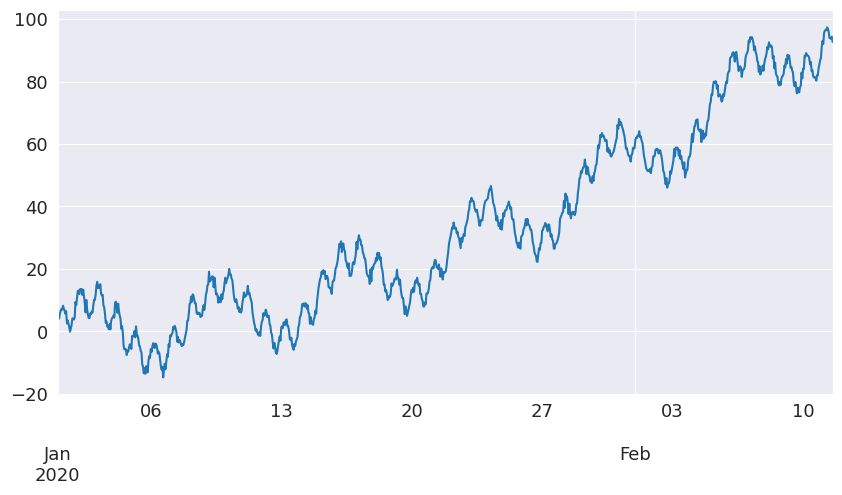

In [7]:
df["y"].plot(figsize=[10, 5])

In [8]:
mstl = MSTL(df["y"], periods=[24, 24 * 7])
res = mstl.fit()

In [9]:
res.seasonal.head()

,seasonal_24,seasonal_168
2020-01-01 00:00:00,1.323605,1.238373
2020-01-01 01:00:00,2.719489,2.471053
2020-01-01 02:00:00,3.866074,1.971769
2020-01-01 03:00:00,4.687790,2.101338
2020-01-01 04:00:00,3.625440,3.994422


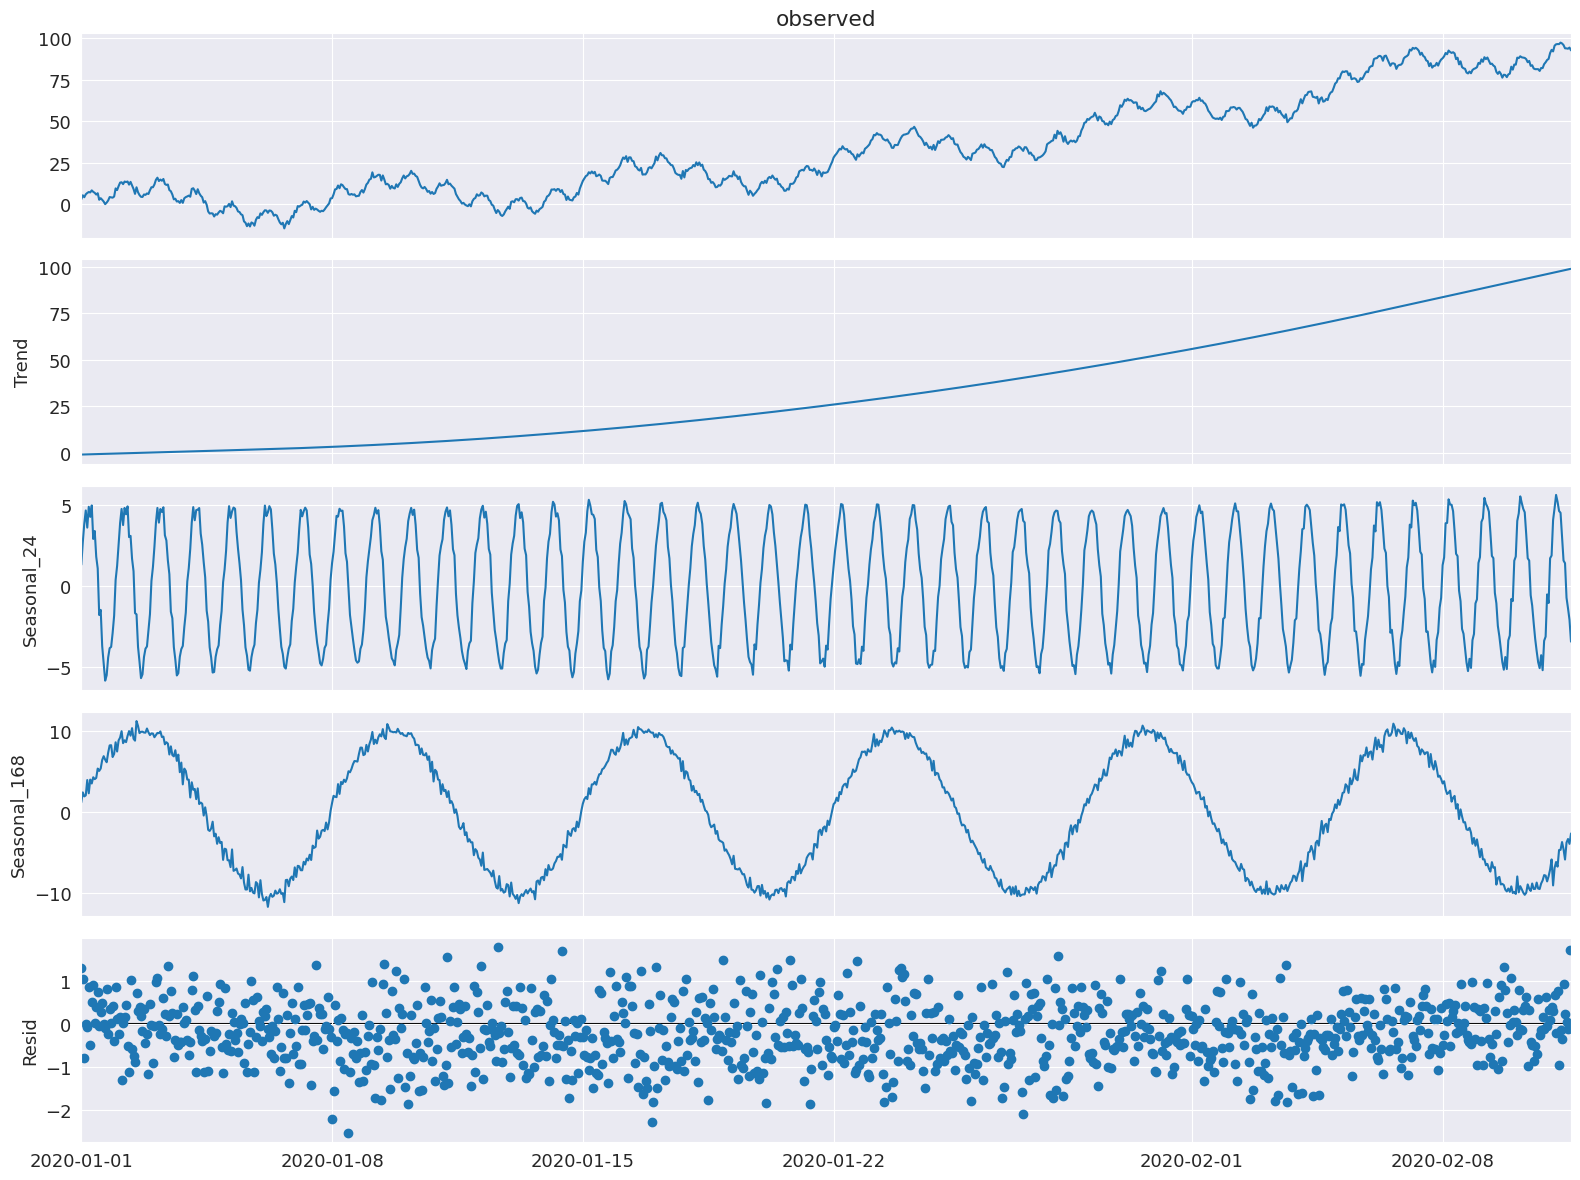

In [10]:
ax = res.plot()

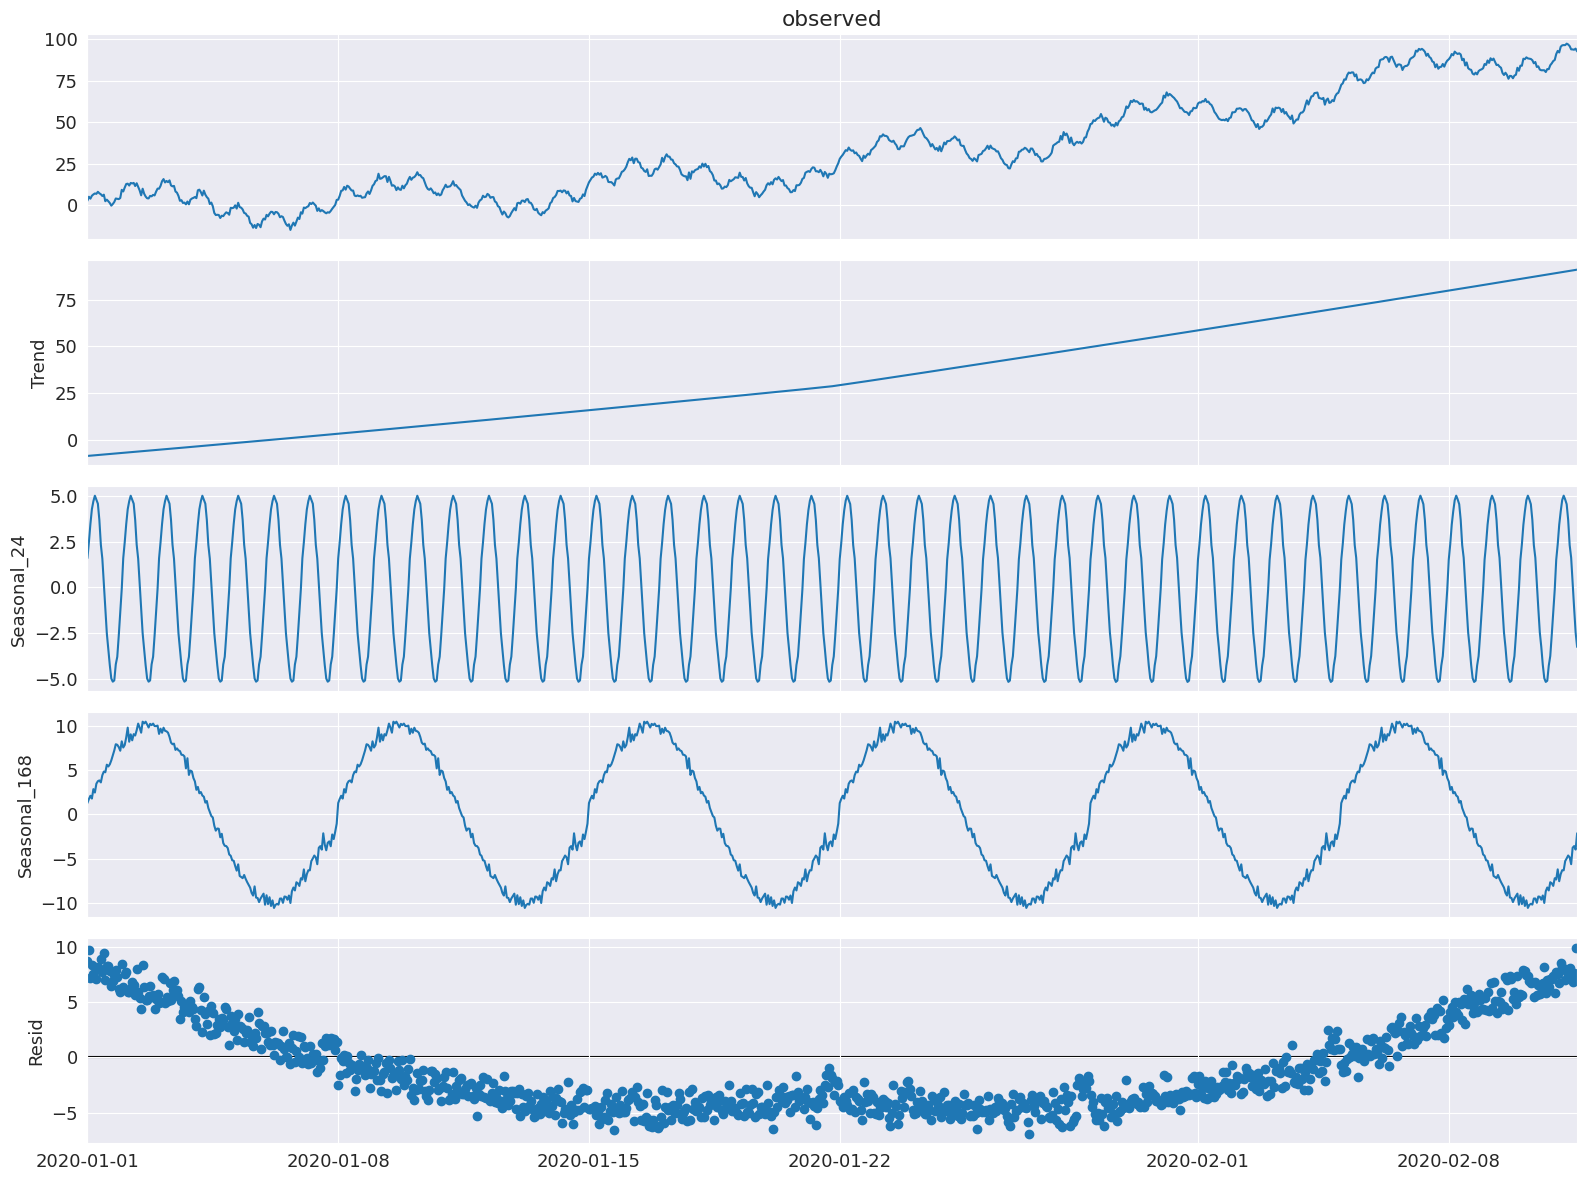

In [11]:
mstl = MSTL(
    df,
    periods=[24, 24 * 7],  # The periods and windows must be the same length and will correspond to one another.
    windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
    iterate=3,
    stl_kwargs={
                "trend":1001, # Setting this large will force the trend to be smoother.
                "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
               }
)
res = mstl.fit()
ax = res.plot()

In [17]:
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

In [32]:
df.head()

,Date,Period,OperationalLessIndustrial,Industrial,ds
0,2002-01-01,1,3535.867064,1086.132936,2002-01-01 00:00:00
1,2002-01-01,2,3383.499028,1088.500972,2002-01-01 00:30:00
2,2002-01-01,3,3655.527552,1084.472448,2002-01-01 01:00:00
3,2002-01-01,4,3510.446636,1085.553364,2002-01-01 01:30:00
4,2002-01-01,5,3294.697156,1081.302844,2002-01-01 02:00:00


In [22]:
df["Date"] = df["Date"].apply(lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days"))
df["ds"] = df["Date"] + pd.to_timedelta((df["Period"]-1)*30, unit="m")

In [23]:
timeseries = df[["ds", "OperationalLessIndustrial"]]
timeseries.columns = ["ds", "y"] # Rename to OperationalLessIndustrial to y for simplicity.

# Filter for first 149 days of 2012.
start_date = pd.to_datetime("2012-01-01")
end_date = start_date + pd.Timedelta("149D")
mask = (timeseries["ds"] >= start_date) & (timeseries["ds"] < end_date)
timeseries = timeseries[mask]

# Resample to hourly
timeseries = timeseries.set_index("ds").resample("H").sum()
timeseries.head()

/tmp/ipykernel_2520/185151541.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timeseries = timeseries.set_index("ds").resample("H").sum()


,y
ds,
2012-01-01 00:00:00,7926.529376
2012-01-01 01:00:00,7901.826990
2012-01-01 02:00:00,7255.721350
2012-01-01 03:00:00,6792.503352
2012-01-01 04:00:00,6635.984460


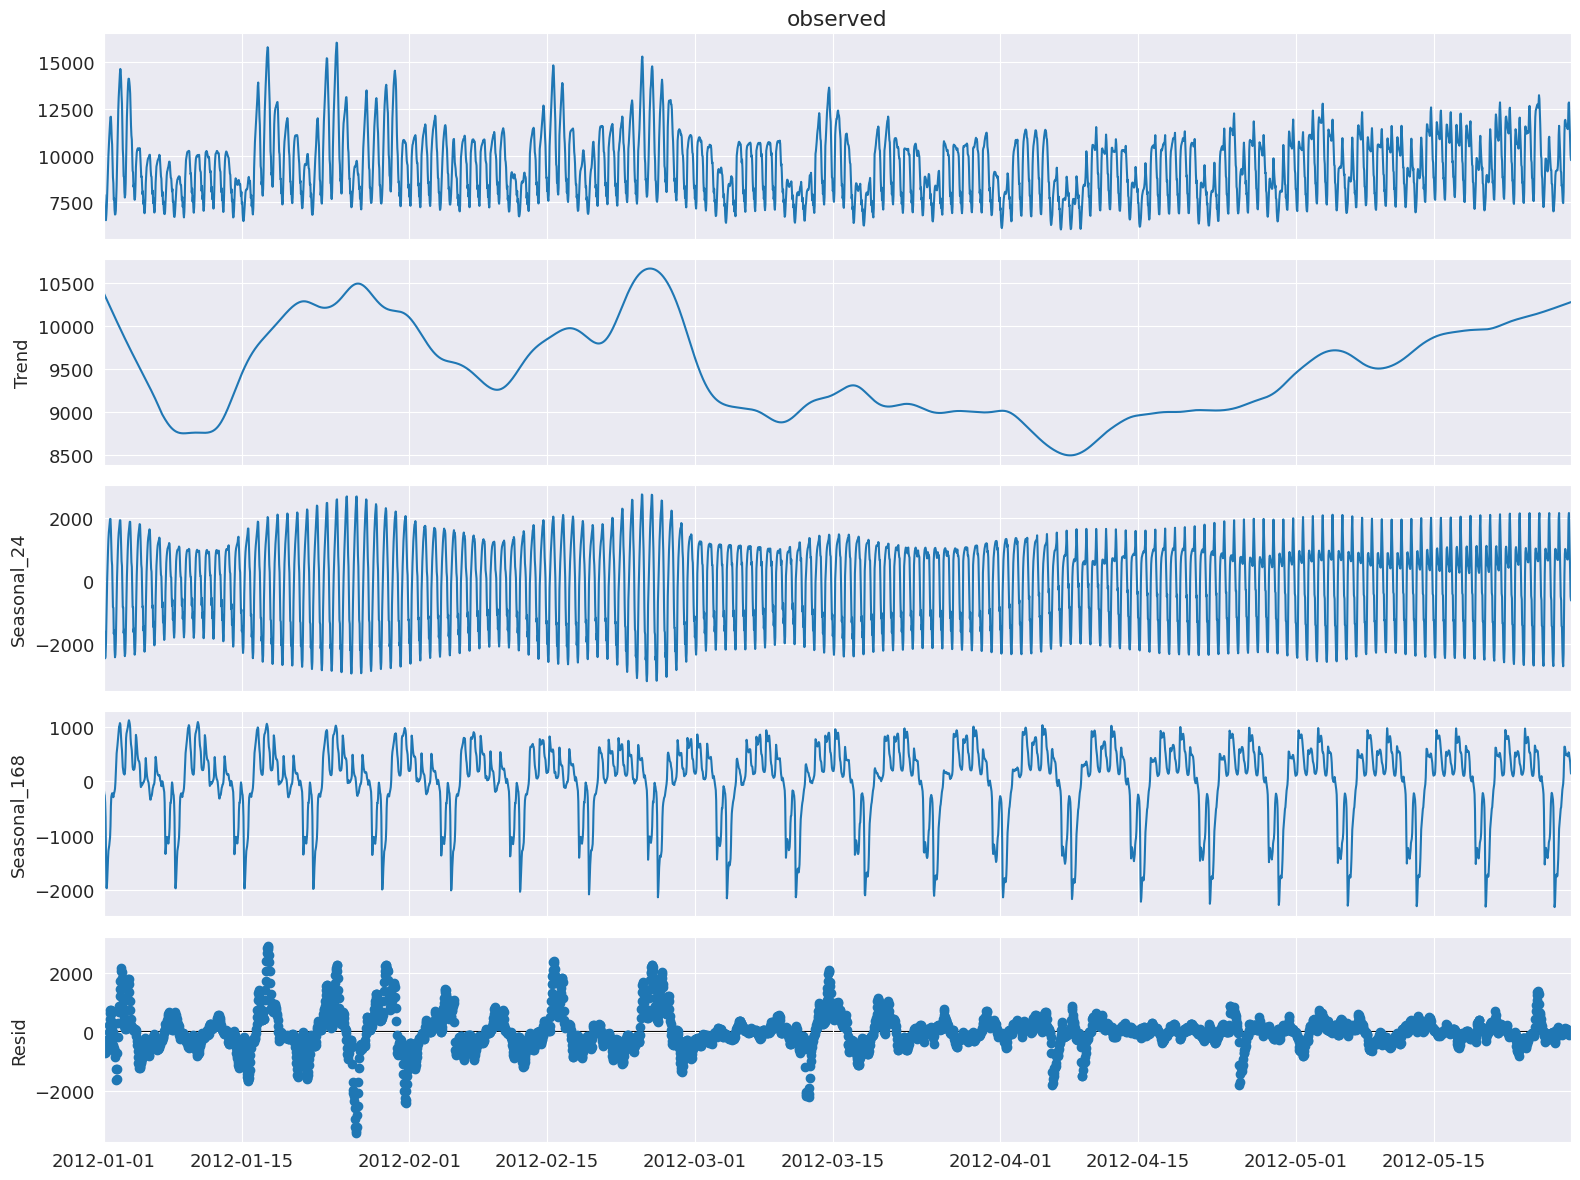

In [25]:
mstl = MSTL(timeseries["y"], periods=[24, 24 * 7], iterate=3, stl_kwargs={"seasonal_deg": 0,
                                                                          "inner_iter": 2,
                                                                          "outer_iter": 0})
res = mstl.fit() # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()

In [26]:
res.seasonal.head()

,seasonal_24,seasonal_168
ds,,
2012-01-01 00:00:00,-1685.986297,-161.807086
2012-01-01 01:00:00,-1591.640845,-229.788887
2012-01-01 02:00:00,-2192.989492,-260.121300
2012-01-01 03:00:00,-2442.169359,-388.484499
2012-01-01 04:00:00,-2357.492551,-660.245476


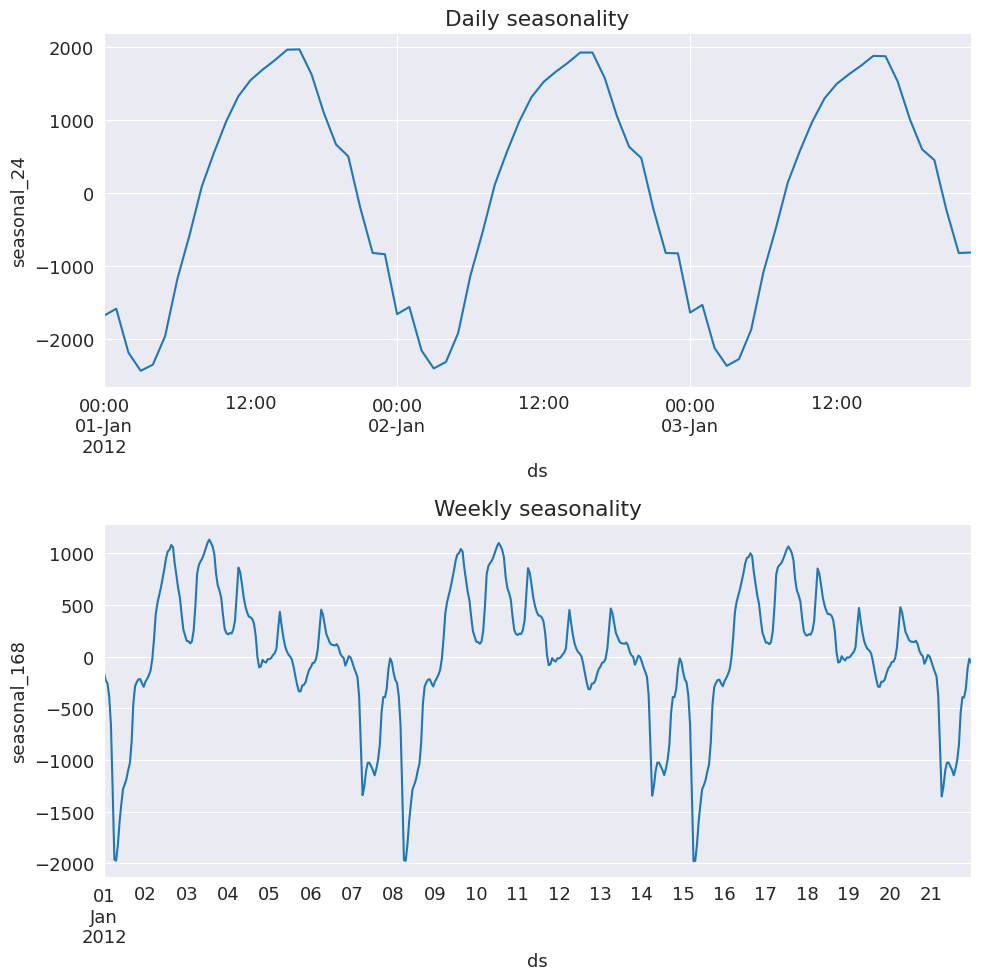

In [27]:
fig, ax = plt.subplots(nrows=2, figsize=[10,10])
res.seasonal["seasonal_24"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal["seasonal_168"].iloc[:24*7*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")

plt.tight_layout()


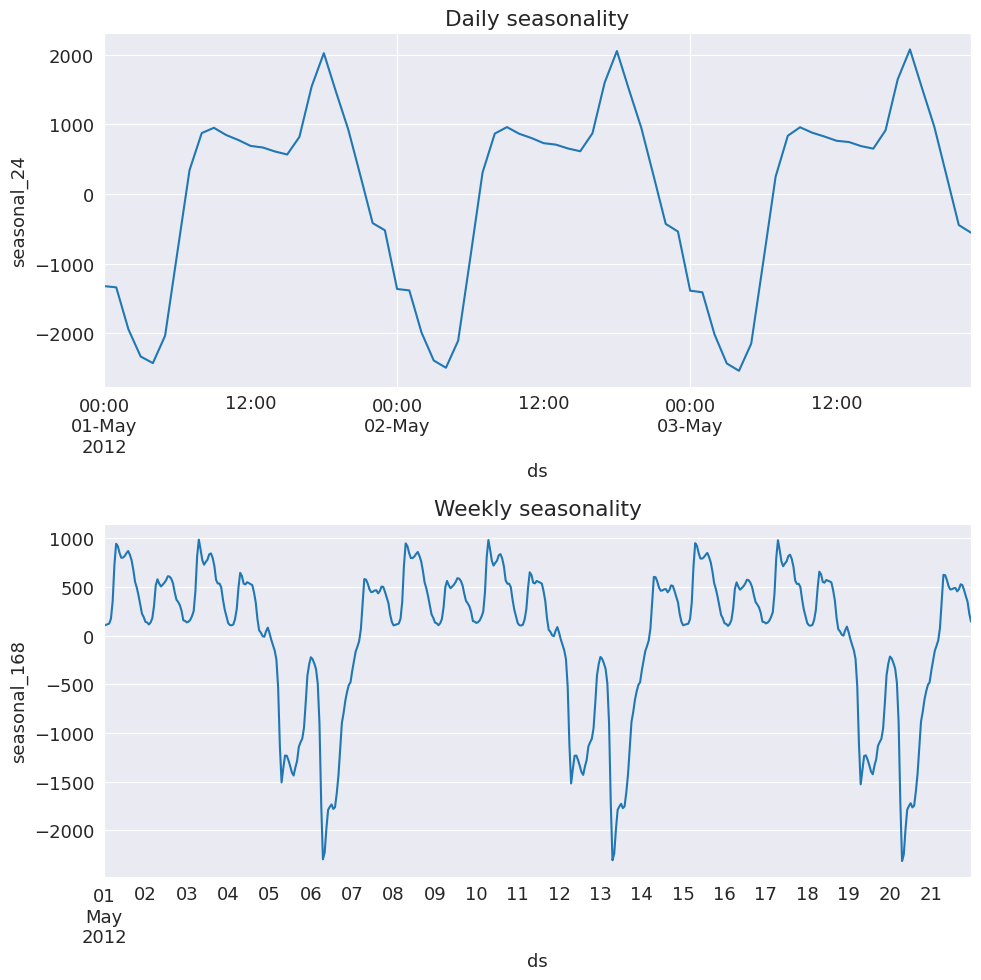

In [28]:
fig, ax = plt.subplots(nrows=2, figsize=[10,10])
mask = res.seasonal.index.month==5
res.seasonal[mask]["seasonal_24"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal[mask]["seasonal_168"].iloc[:24*7*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")

plt.tight_layout()


In [29]:
display(res.trend.head()) # trend component
display(res.resid.head()) # residual component


ds
2012-01-01 00:00:00    10373.942662
2012-01-01 01:00:00    10363.488489
2012-01-01 02:00:00    10353.037721
2012-01-01 03:00:00    10342.590527
2012-01-01 04:00:00    10332.147100
Freq: h, Name: trend, dtype: float64

ds
2012-01-01 00:00:00   -599.619903
2012-01-01 01:00:00   -640.231767
2012-01-01 02:00:00   -644.205579
2012-01-01 03:00:00   -719.433316
2012-01-01 04:00:00   -678.424613
Freq: h, Name: resid, dtype: float64